<a href="https://colab.research.google.com/github/leshcsr/Reto3002b/blob/main/Deteccion_de_plagio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo
---




Construir un sistema de detección de plagio en código fuente utilizando técnicas de procesamiento de lenguaje natural (PLN), Word2Vec con Skip-gram y análisis de similaridad semántica mediante embeddings.

#Introducción
---
La detección de plagio en código fuente es un problema importante en educación y desarrollo de software. El objetivo es detectar cuándo un código ha sido copiado de otro código.
Utilizaremos embeddings, Word2Vec y modelos neuronales para capturar similitudes semánticas entre fragmentos de código.

**Flujo de trabajo**
1. Preprocesamiento del dataset
2. Word2Vec con arquitectura Skip-gram
3. Generación de embeddings
4. Modelo de clasificación

---
#Paso 1. Cargado y preprocesamiento del dataset (corpus)

Iniciamos cargando las librerías que vamos a necesitar.
Las de keras son para entrenar nuestro modelo que nos ayudará a saber si el código es plagio o no.





In [ ]:
!pip install javalang
!pip install --upgrade --force-reinstall numpy gensim

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [ ]:
import javalang

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import pandas as pd
import os
import re

import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import tensorflow as tf
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential, load_model
import pickle

In [ ]:
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"

base_path = "/content/drive/MyDrive/Conplag_version_Dataset"

labels_df = pd.read_csv(f"{base_path}/labels.csv")
train_pairs_df = pd.read_csv(f"{base_path}/train_pairs.csv")
test_pairs_df = pd.read_csv(f"{base_path}/test_pairs.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
print("Etiquetas:")
print(labels_df.head())

print("\nTrain pairs:")
print(train_pairs_df.head())

print("\nTest pairs:")
print(test_pairs_df.head())

Etiquetas:
       sub1      sub2  problem  verdict
0  0fd5b95a  6490bbe8       19        0
1  464a03b8  ff1fc018       20        0
2  3e6def38  548ffb07       14        1
3  0b91922c  71a4f6d2        6        0
4  9291ca83  d6fb3b9e       15        0

Train pairs:
   2470b521_f6ca6fc8
0  a8e2cefc_ee270b2a
1  90f01508_e00b1794
2  16857116_f3d7ce08
3  51151974_c23278ec
4  00f79486_ce0b2178

Test pairs:
   464a03b8_ff1fc018
0  3e6def38_548ffb07
1  213340b3_35f0c004
2  7bc92b7f_9028caf7
3  6f393cfe_b185d034
4  1dab88fb_bac616ee


El dataset que seleccionamos cuenta con la siguiente estructura:

directorio   ->   carpetas con los códigos fuentes nombradas con la pareja de ids de los códigos

In [ ]:
def read_code_pair(base_path, pair_id):
    pair_dir = os.path.join(base_path, "version_2", str(pair_id))

    if not os.path.exists(pair_dir):
        print(f"Directorio no encontrado: {pair_dir}")
        return None, None

    files = sorted(os.listdir(pair_dir))
    if len(files) != 2:
        print(f"No estan los 2 archivos en: {pair_dir}")
        return None, None

    code1_path = os.path.join(pair_dir, files[0])
    code2_path = os.path.join(pair_dir, files[1])

    with open(code1_path, 'r', encoding='utf-8', errors='ignore') as f:
        code1 = f.read()
    with open(code2_path, 'r', encoding='utf-8', errors='ignore') as f:
        code2 = f.read()

    return code1, code2


Queremos enfocarnos en detectar el plagio desde la estructura y semántica del código, por lo tanto nuestra forma de preprocesar los datos será ignorar los comentarios, Tokenización básica y Normalización de identificadores para que esto no represente diferencias significativas para nuestro modelo.

In [ ]:
pre_compile = re.compile(r'//.*')
pre_compile2 = re.compile(r'/\*[\s\S]*?\*/')

def remove_comments(code):
    code = pre_compile.sub('', code)
    code = pre_compile2.sub('',code)
    return code

def remove_blank_lines(code):
    lines = code.splitlines()
    return "\n".join([line.strip() for line in lines if line.strip()])

def tokenize_with_javalang(code):
    try:
        tokens = list(javalang.tokenizer.tokenize(code))
        return [token.value for token in tokens]
    except Exception as e:
        print("Tokenization error:", e)
        return []

def normalize_identifiers(tokens):
    keywords = {
        'if', 'else', 'while', 'for', 'return', 'int', 'float',
        'double', 'String', 'public', 'private', 'protected', 'class',
        'void', 'static', 'new', 'import', 'package', 'boolean', 'true', 'false'
    }

    var_map = {}
    var_count = 1
    normalized = []

    for token in tokens:
        if token not in keywords and re.match(r'^[a-zA-Z_][a-zA-Z0-9_]*$', token):
            if token not in var_map:
                var_map[token] = f'VAR_{var_count}'
                var_count += 1
            normalized.append(var_map[token])
        else:
            normalized.append(token)
    return normalized

def preprocess_code(code):
    code = remove_comments(code)
    code = remove_blank_lines(code)
    tokens = tokenize_with_javalang(code)
    normalized_tokens = normalize_identifiers(tokens)
    return normalized_tokens



In [ ]:

def load_and_preprocess_code(base_path, pair_folder, submission_id):
    file_path = os.path.join(base_path, "version_2", pair_folder, f"{submission_id}.java")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        raw_code = f.read()
        tokens = preprocess_code(raw_code)
        return tokens

In [ ]:
def build_dataset(pair_df, labels_df, base_path):
    data = []
    for _, row in pair_df.iterrows():
        # DataFrame has columns 'sub1' and 'sub2'
        if 'sub1' in row and 'sub2' in row:
            sub1 = str(row['sub1'])
            sub2 = str(row['sub2'])
            pair_folder = f"{sub1}_{sub2}"
        else:
            # fallback for pair string like '123_456'
            pair_str = row[0]
            if '_' not in pair_str:
                continue
            sub1, sub2 = pair_str.split('_')
            pair_folder = f"{sub1}_{sub2}"

        # Load and preprocess code
        tokens1 = load_and_preprocess_code(base_path, pair_folder, sub1)
        tokens2 = load_and_preprocess_code(base_path, pair_folder, sub2)

        if tokens1 is None or tokens2 is None:
            continue

        # Attempt to find label
        label_row = labels_df[
          ((labels_df['sub1'].astype(str) == sub1) & (labels_df['sub2'].astype(str) == sub2)) |
          ((labels_df['sub1'].astype(str) == sub2) & (labels_df['sub2'].astype(str) == sub1))
        ]

        if not label_row.empty:
            label = int(label_row.iloc[0]['verdict'])
            data.append((tokens1, tokens2, label))
        else:
            # No label found, treat as unlabeled (e.g. test set)
            data.append((tokens1, tokens2, None))

    return data



In [ ]:
train_data = build_dataset(train_pairs_df, labels_df, base_path)
test_data = build_dataset(test_pairs_df, labels_df, base_path)

<ipython-input-43-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-43-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-43-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-43-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, int

In [ ]:

with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print(os.path.getsize('train_data.pkl'))

812791


In [ ]:
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

---
#Paso 2. Entrenamiento de Word2vec con Skip-Gram


In [ ]:
all_tokens = [tokens for pair in train_data for tokens in pair[:2]]
all_tokens2 = [tokens for pair in test_data for tokens in pair[:2]]

all_tokens.extend(all_tokens2)
w2v_model = Word2Vec(sentences=all_tokens, vector_size=256, window=5, min_count=1, sg=5)

In [ ]:
w2v_model.train(all_tokens, total_examples=len(all_tokens), epochs=25)
sims = w2v_model.wv.most_similar('import', topn=10)
print(sims)
w2v_model.save("word2vec.model")

[('VAR_1', 0.9430750012397766), ('VAR_2', 0.8925239443778992), ('VAR_3', 0.6967570781707764), ('VAR_4', 0.5921514630317688), ('*', 0.5754433274269104), ('.', 0.5653482675552368), ('class', 0.5611092448234558), ('public', 0.5130074620246887), ('VAR_5', 0.5024308562278748), ('VAR_6', 0.48531603813171387)]


---
#Paso 3. Generación de embeddings para los pares

In [ ]:
w2v_model.wv.get_vector('import')

array([-7.03373030e-02,  2.34459460e-01,  8.99845734e-02, -5.10548651e-01,
        2.64990292e-02,  5.78635573e-01, -4.66674894e-01, -2.08949625e-01,
        2.71483868e-01,  3.83946061e-01,  1.43196613e-01,  7.31629459e-03,
       -6.19379878e-02,  6.70540512e-01, -8.84695172e-01, -4.25174795e-02,
        1.76515579e-01,  2.18743339e-01, -5.16759098e-01,  4.41520840e-01,
        1.04421310e-01,  3.89910519e-01,  1.31891757e-01, -6.34262571e-03,
        5.01463771e-01,  1.21105187e-01, -7.24898756e-01,  1.92381635e-01,
        3.51875275e-02, -2.71131158e-01, -4.91416663e-01, -9.05915871e-02,
       -2.21489325e-01, -6.82212738e-03,  1.71632037e-01,  1.39300719e-01,
       -7.91585147e-02, -5.62652871e-02,  2.80459553e-01,  7.55333304e-01,
        2.44566336e-01, -2.27494821e-01, -8.35071877e-02, -9.45457071e-02,
       -4.30182368e-01, -2.03235224e-01,  3.96626115e-01, -6.62365481e-02,
       -1.70111526e-02,  3.62675756e-01, -3.83585155e-01,  2.80460864e-01,
       -1.74103588e-01, -

In [ ]:
def embed_code(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def prepare_dataset(data, model):
    X = []
    y = []

    for tokens1, tokens2, label in data:
        vec1 = embed_code(tokens1, w2v_model)
        vec2 = embed_code(tokens2, w2v_model)


        combined = np.concatenate([vec1, vec2, np.abs(vec1 - vec2)])

        X.append(combined)
        if label is not None:
            y.append(label)

    return np.array(X), np.array(y)


In [ ]:
X_train, y_train = prepare_dataset(train_data, w2v_model)
X_test, y_test = prepare_dataset(test_data, w2v_model)

In [ ]:
X_train

array([[ 0.00594318, -0.03698281, -0.05388885, ...,  0.03129768,
         0.00434924,  0.01648096],
       [-0.00322249, -0.03087523, -0.03321281, ...,  0.01085403,
         0.00845325,  0.00802996],
       [ 0.0033762 , -0.00373362, -0.01192778, ...,  0.00121024,
         0.00159014,  0.00347824],
       ...,
       [-0.00111539, -0.00907057, -0.00915996, ...,  0.0143064 ,
         0.00224148,  0.03201105],
       [-0.00183072, -0.02042522, -0.03672077, ...,  0.00018822,
         0.01791208,  0.00539751],
       [ 0.00677287, -0.01581133, -0.03224672, ...,  0.01336438,
         0.00534716,  0.00124497]], dtype=float32)

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (229, 768), y_train shape: (229,)
X_test shape: (680, 768), y_test shape: (680,)


In [ ]:
input_dim = X_train.shape[1]

In [ ]:
model = Sequential([
    Dense(8, input_dim=input_dim, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=20,
    verbose=1
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.6704 - loss: 0.6906 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.7265 - val_loss: 0.6803 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7458 - loss: 0.6758 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.7265 - val_loss: 0.6633 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6887 - loss: 0.6641 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.7265 - val_loss: 0.6431 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7075 - loss: 0.6431 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.7265 - val_loss: 0.6188 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.70

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión: {scores[1]*100:.2f}%")
print(f"Precisión: {scores[2]*100:.2f}% | Recall: {scores[3]*100:.2f}%")

model.save("plagio_detector.h5")


Precisión: 81.62%
Precisión: 82.80% | Recall: 41.40%


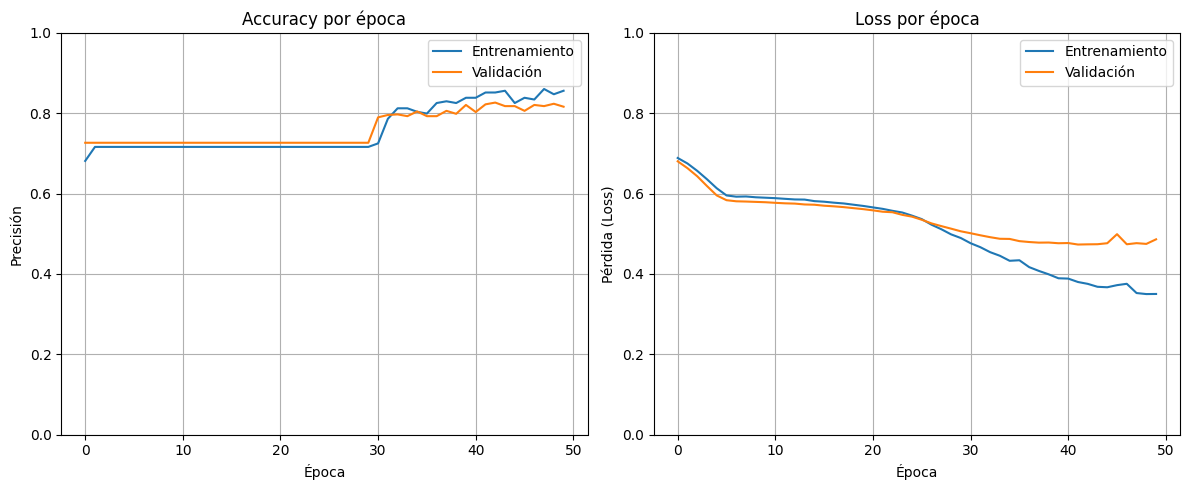

In [63]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(y_test, steps = 25)
print(f'\ntest ac  {test_acc:.4f}:\n')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7920 - loss: 0.4921 - precision_2: 0.8267 - recall_2: 0.3756
\X_test [0.4862096905708313, 0.8161764740943909, 0.8279569745063782, 0.4139784872531891]:



In [ ]:
print(classification_report(y_test, y_pred, target_names=["No Plagio", "Plagio"]))

NameError: name 'y_pred' is not defined

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


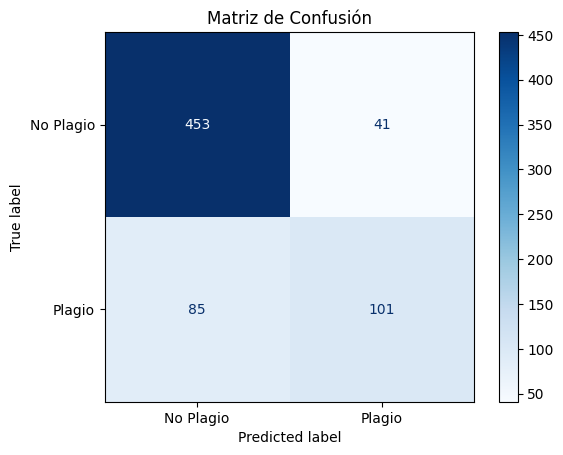

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Plagio", "Plagio"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()


In [ ]:
class_names = ['No Plagio', 'Plagio']

---
#Paso 4. Detección del plagio

In [ ]:
w2v_model = Word2Vec.load("word2vec.model")
plagiarism_model = load_model("plagio_detector.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_pair_embedding(code1, code2, w2v_model):
    tokens1 = preprocess_code(code1)
    tokens2 = preprocess_code(code2)

    vec1 = embed_code(tokens1, w2v_model)
    vec2 = embed_code(tokens2, w2v_model)

    similarity = cosine_similarity([vec1], [vec2])[0][0]

    combined = np.concatenate([vec1, vec2, np.abs(vec1 - vec2)])
    features = combined.reshape(1, -1)

    prediction = model.predict(features)[0][0]

    print(f"\n Similitud coseno: {similarity:.4f}")
    print(f" Probabilidad (modelo) de plagio: {prediction:.4f}")

    if similarity < 0.366:
        print("Resultado: No hay plagio (baja similitud)")
    elif similarity < 0.566:
        print("Resultado: Posible similitud, pero no concluyente")
    else:
        print("Resultado: ¡Plagio detectado!")

    return combined.reshape(1, -1)

In [ ]:
def predict_plagiarism(code1, code2, model, w2v_model):
    features = prepare_pair_embedding(code1, code2, w2v_model)
    prediction = model.predict(features)[0][0]
    print(f"\nProbabilidad de plagio: {prediction:.4f}")
    certainty = 0.
    if prediction>0.566:
      print("Resultado: UPS! PLAGIO")
      certainty = float(np.absolute(prediction - 0.566)/0.434)
    else:
      print("Resultado: NO HAY PLAGIO")
      certainty = float(np.absolute(prediction - 0.566)/0.566)
    print(f"\Certeza del modelo: {certainty:.4f}")
    return prediction

In [ ]:
def main():

    while True:
        print("\n Sube dos archivos `.java` para comparar plagio")
        uploaded = files.upload()

        file_names = list(uploaded.keys())
        if len(file_names) != 2:
            print("Debes subir exactamente 2 archivos.")
            continue

        with open(file_names[0], 'r', encoding='utf-8', errors='ignore') as f1:
            code1 = f1.read()
        with open(file_names[1], 'r', encoding='utf-8', errors='ignore') as f2:
            code2 = f2.read()

        print(f"\n------ Archivo 1: {file_names[0]}")
        print(f"------ Archivo 2: {file_names[1]}")
        predict_plagiarism(code1, code2, plagiarism_model, w2v_model)

        print("\n¿Probar otros archivos? (s/n)")
        if input().strip().lower() != 's':
            break

main()


 Sube dos archivos `.java` para comparar plagio


Saving fb312dc6.java to fb312dc6 (6).java
Saving 00f79486.java to 00f79486 (3).java

------ Archivo 1: fb312dc6 (6).java
------ Archivo 2: 00f79486 (3).java
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

📊 Similitud coseno: 0.9869
🤖 Probabilidad (modelo) de plagio: 0.2643
🔴 Resultado: ¡Plagio detectado!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Probabilidad de plagio: 0.2643
Resultado: 🟢 NO HAY PLAGIO
\Certeza del modelo: 0.5331

¿Probar otros archivos? (s/n)
s

 Sube dos archivos `.java` para comparar plagio


Saving b434c275.java to b434c275.java
Saving fdc4f384.java to fdc4f384.java

------ Archivo 1: b434c275.java
------ Archivo 2: fdc4f384.java
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

📊 Similitud coseno: 0.9996
🤖 Probabilidad (modelo) de plagio: 0.3060
🔴 Resultado: ¡Plagio detectado!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Probabilidad de plagio: 0.3060
Resultado: 🟢 NO HAY PLAGIO
\Certeza del modelo: 0.4594

¿Probar otros archivos? (s/n)
n
